## Short Term Wind Climate 
**5. Filter data: (report page 30 - 33)**
- Outliers in wind speed and direction 
- Datagaps: Done in 'Overwiev'

**6. Interpolate:**
- Interpolate to the  one height of interest (= 150 meters for current turbine)

**7. Compare the both met masts:**
- Scatterplot: windspeed 150 m height mast one against windspeed 150m height mast 2 
- Same with the wind direction 
- Correlate with r^2 - linear correlation for both

**8. Short Term Wind Analysis**
- Mean, stdv of monthly and annual ws 
- Wind roses 
- Select parameters for Weibull model 
- Plot Weibull model 
- Diurnal profile of wind speed (blue) and wind direction (red) at HKW at 100 m MSL
- Monthly profile of the wind speed 
- Power curve of such a turbine
- Annual production of one turbine
- Annual production of wind farm


### Import Libraries and Load Data 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
from scipy.stats import linregress
from matplotlib.projections.polar import PolarAxes
from windrose import WindroseAxes

In [3]:
# Data Paths
bouy6_path = 'data/measurements/2023-11-06_Buoy6_BSH_N-9.nc'
bouy2_path = 'data/measurements/2023-11-09_Buoy2_BSH_N-9.nc'
era5_path = 'data/reanalysis/'
turbines_existing_path = 'data/turbine-info/coordinates/existing/'
turbines_planned_future_path = 'data/turbine-info/coordinates/planned_future/'
turbines_planned_in_operation_before_2030_path = 'data/turbine-info/coordinates/planned_in_operation_before_2030/'
turbines_planned_netherlands_path = 'data/turbine-info/coordinates/planned_netherlands/'
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
shapefiles_DEU_path = 'data/shapefiles/DEU/*'
shapefiles_DNK_path = 'data/shapefiles/DNK/*'
shapefiles_NLD_path = 'data/shapefiles/NLD/*'
turbine_power_curves_path = 'data/turbine-info/power_curves/'

From 'Overview' we decided to work with: buoy_6_measured and buoy_2_correlated_with_6 bcs. buoy 2 had a lot of data gaps (not a complete year measured)

In [4]:
#Load the datafiles in xr and netcdf 

xrbuoy6 = xr.open_dataset(bouy6_path)
xrbuoy2 = xr.open_dataset(bouy2_path)

buoy2_file = Dataset(bouy2_path)
buoy6_file = Dataset(bouy6_path)

In [5]:
#xrbuoy2

In [6]:
#xrbuoy6

### 4. Filter the Data

In [7]:
# select the data of interest for now
time2 = xrbuoy2.variables['time'][:]
windspeed2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_speed'][:]
winddirection_buoy_2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_from_direction'][:]

In [8]:
time6 = xrbuoy6.variables['time'][:]
windspeed6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_speed'][:]
winddirection_buoy_6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_from_direction'][:]

In [9]:
def create_buoy_dataframes(time, windspeed_140, winddirection_140, windspeed_200, winddirection_200):
    # Convert time variables to pandas datetime (though it's already in datetime64[ns] format)
    time = pd.to_datetime(time, unit='ns', origin='unix')
    
    # Create a single DataFrame for the buoy with measurements at 140m and 200m heights
    df_buoy = pd.DataFrame({
        'time': time,
        'wind_speed_140m': windspeed_140,
        'wind_direction_140m': winddirection_140,
        'wind_speed_200m': windspeed_200,
        'wind_direction_200m': winddirection_200
    }).set_index('time')
    
    return df_buoy

#heights for buoy 6: 14 42 94 140 200 250
#indices for the heights: 0 1 2 3 4 5 
#In future we gonna work only with the height measurements 
#of 140 and 200 meters to interpolate these two heights to the hub height of 150 m 
#So that is why we only convert windspeeds[:, 0, 0, 3] and winddirection_buoy_2[:, 0, 0, 3] for example.
#Because these indicies stand for the two heights of interest.

df_buoy_2 = create_buoy_dataframes(
    time2,
    windspeed2[:, 0, 0, 3],
    winddirection_buoy_2[:, 0, 0, 3],
    windspeed2[:, 0, 0, 4],
    winddirection_buoy_2[:, 0, 0, 4]
)

df_buoy_6 = create_buoy_dataframes(
    time6,
    windspeed6[:, 0, 0, 3],
    winddirection_buoy_6[:, 0, 0, 3],
    windspeed6[:, 0, 0, 4],
    winddirection_buoy_6[:, 0, 0, 4]
)


In [10]:
def check_data_gaps(dataframe):
    
    dataframe.index = dataframe.index.floor('s')  # Truncate microseconds

    # Round timestamps to the nearest 10 minutes
    dataframe.index = dataframe.index.round('10min')
    
    # Generate a complete time range based on the data frequency
    full_time_range = pd.date_range(start=dataframe.index.min(), end=dataframe.index.max(), freq='10min')
    dataframe = dataframe.reindex(full_time_range)
    
    missing_data = dataframe[dataframe.isnull().any(axis=1)]
    
    total_expected = len(full_time_range)
    total_actual = len(dataframe.dropna())
    availability = (total_actual / total_expected) * 100
    
    print(f"Data Availability is {availability:.2f}%")
    
    if not missing_data.empty:
        print("Missing time periods are:")
        print(missing_data.index)
    else:
        print("No data gaps are found.")
    
    return missing_data

#This looks for duplicates and NaN values at the same time!
def drop_duplicates(dataframe):
    # Identify duplicate rows
    duplicates = dataframe[dataframe.duplicated(keep=False)]
    
    # Drop duplicates
    no_duplicate_data = dataframe.drop_duplicates()
    
    # Calculate data availability
    total_expected = len(dataframe)
    total_actual = len(no_duplicate_data)
    availability = (total_actual / total_expected) * 100
    
    print(f"Data Availability is {availability:.2f}%")
    
    if not duplicates.empty:
        # Set display options to show the entire DataFrame
        #with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(duplicates)
    else:
        print("No duplicates are found.")
    
    return duplicates

def explore_and_prefilter_df(dataframe):
   check_data_gaps(dataframe)
   drop_duplicates(dataframe)

explore_and_prefilter_df(df_buoy_2)

Data Availability is 81.25%
Missing time periods are:
DatetimeIndex(['2022-03-07 08:40:00', '2022-03-07 08:50:00',
               '2022-03-07 12:00:00', '2022-03-07 16:00:00',
               '2022-03-07 16:10:00', '2022-03-07 16:20:00',
               '2022-03-07 16:50:00', '2022-03-07 18:10:00',
               '2022-03-14 06:10:00', '2022-03-14 09:10:00',
               ...
               '2023-06-15 22:20:00', '2023-06-15 22:30:00',
               '2023-06-15 22:40:00', '2023-06-15 22:50:00',
               '2023-06-15 23:00:00', '2023-06-15 23:10:00',
               '2023-06-15 23:20:00', '2023-06-15 23:30:00',
               '2023-06-15 23:40:00', '2023-06-15 23:50:00'],
              dtype='datetime64[ns]', length=12691, freq=None)
Data Availability is 82.22%
                     wind_speed_140m  wind_direction_140m  wind_speed_200m  \
time                                                                         
2022-03-07 08:50:00              NaN                  NaN            

In [11]:
def replace_nan_and_select_1yr(dataframe):
    dataframe = dataframe.fillna(dataframe.mean())
    dataframe = dataframe.iloc[:52704]
    return dataframe

filtered_buoy2 = replace_nan_and_select_1yr(df_buoy_2)
filtered_buoy2

,wind_speed_140m,wind_direction_140m,wind_speed_200m,wind_direction_200m
time,,,,
2022-03-03 00:00:00,10.065,105.370,9.347,104.819
2022-03-03 00:10:00,7.415,104.801,8.105,103.625
2022-03-03 00:20:00,10.701,106.720,9.088,107.784
2022-03-03 00:30:00,6.500,111.699,7.360,111.669
2022-03-03 00:40:00,8.170,110.464,6.746,117.983
...,...,...,...,...
2023-03-03 23:10:00,11.711,326.565,12.164,329.460
2023-03-03 23:20:00,13.002,336.780,10.979,337.685
2023-03-03 23:30:00,11.098,334.191,12.934,333.538


In [12]:
explore_and_prefilter_df(df_buoy_6)
filtered_buoy6 = replace_nan_and_select_1yr(df_buoy_6)
filtered_buoy6

Data Availability is 96.39%
Missing time periods are:
DatetimeIndex(['2022-03-07 08:40:00', '2022-03-07 08:50:00',
               '2022-03-14 06:10:00', '2022-03-14 09:10:00',
               '2022-03-14 09:20:00', '2022-03-14 09:30:00',
               '2022-03-14 09:40:00', '2022-03-14 09:50:00',
               '2022-03-14 10:00:00', '2022-03-14 10:10:00',
               ...
               '2023-04-01 03:20:00', '2023-04-01 03:30:00',
               '2023-04-01 03:40:00', '2023-04-01 03:50:00',
               '2023-04-01 04:00:00', '2023-04-01 04:10:00',
               '2023-04-01 04:20:00', '2023-04-01 04:30:00',
               '2023-04-01 04:40:00', '2023-04-04 01:20:00'],
              dtype='datetime64[ns]', length=2066, freq=None)
Data Availability is 97.32%
                     wind_speed_140m  wind_direction_140m  wind_speed_200m  \
time                                                                         
2022-03-07 08:50:00              NaN                  NaN             

,wind_speed_140m,wind_direction_140m,wind_speed_200m,wind_direction_200m
time,,,,
2022-03-03 00:00:00,8.34,104.39,8.49,105.91
2022-03-03 00:10:00,7.89,104.47,8.08,105.97
2022-03-03 00:20:00,7.70,107.12,8.04,109.15
2022-03-03 00:30:00,7.05,112.57,7.61,117.84
2022-03-03 00:40:00,7.20,113.91,7.92,120.92
...,...,...,...,...
2023-03-03 23:10:00,11.31,330.18,11.37,332.20
2023-03-03 23:20:00,11.94,338.96,12.24,337.41
2023-03-03 23:30:00,11.42,335.37,12.05,334.30


In [13]:
# Assuming 'filtered_buoy6' and 'filtered_buoy2' are your dataframes

def interpolate_dataframe(df, col1, col2, height1, height2, target_height):
    # Calculate the interpolation factor
    factor = (target_height - height1) / (height2 - height1)
    # Perform the interpolation
    df[f'{col1}_{target_height}m'] = df[col1] + factor * (df[col2] - df[col1])
    return df

# Interpolating and adding the results to the dataframe for buoy6
filtered_buoy6 = interpolate_dataframe(filtered_buoy6, 'wind_speed_140m', 'wind_speed_200m', 140, 200, 150)
filtered_buoy6 = interpolate_dataframe(filtered_buoy6, 'wind_direction_140m', 'wind_direction_200m', 140, 200, 150)

# Interpolating and adding the results to the dataframe for buoy2
filtered_buoy2 = interpolate_dataframe(filtered_buoy2, 'wind_speed_140m', 'wind_speed_200m', 140, 200, 150)
filtered_buoy2 = interpolate_dataframe(filtered_buoy2, 'wind_direction_140m', 'wind_direction_200m', 140, 200, 150)

# Check the shapes
print(filtered_buoy6[f'wind_speed_140m_150m'].shape)
print(filtered_buoy6[f'wind_direction_140m_150m'].shape)
print()
print(filtered_buoy2[f'wind_speed_140m_150m'].shape)
print(filtered_buoy2[f'wind_direction_140m_150m'].shape)


(52704,)
(52704,)

(52704,)
(52704,)


### 6. Interpolate

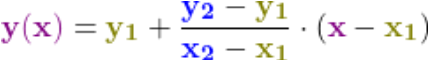

In [14]:
def interpolate_arrays(array1, array2, height1, height2, target_height):

    # Calculate the interpolation factor
    factor = (target_height - height1) / (height2 - height1) #factor = (x-x1)/(x2-x1)
    # Perform the interpolation
    interpolated_array = array1 + factor * (array2 - array1) #formular: y1 + factor *(y2 - y1)

    return interpolated_array

ws6_150m = interpolate_arrays(filtered_buoy6['wind_speed_140m'], filtered_buoy6['wind_speed_200m'], 140, 200, 150)
wd6_150m = interpolate_arrays(filtered_buoy6['wind_direction_140m'], filtered_buoy6['wind_direction_200m'], 140, 200, 150)
ws2_150m = interpolate_arrays(filtered_buoy2['wind_speed_140m'], filtered_buoy2['wind_speed_200m'], 140, 200, 150)
wd2_150m = interpolate_arrays(filtered_buoy2['wind_direction_140m'], filtered_buoy2['wind_direction_200m'], 140, 200, 150)

#test if they have the same shape 
print(ws6_150m.shape)
print(wd6_150m.shape)
print()
print(ws2_150m.shape)
print(wd2_150m.shape)

# Create a new dataframe with the interpolated arrays
df_interpol_height = pd.DataFrame({
    'ws6_150m': ws6_150m,
    'wd6_150m': wd6_150m,
    'ws2_150m': ws2_150m,
    'wd2_150m': wd2_150m
})

df_interpol_height



(52704,)
(52704,)

(52704,)
(52704,)


,ws6_150m,wd6_150m,ws2_150m,wd2_150m
time,,,,
2022-03-03 00:00:00,8.365000,104.643333,9.945333,105.278167
2022-03-03 00:10:00,7.921667,104.720000,7.530000,104.605000
2022-03-03 00:20:00,7.756667,107.458333,10.432167,106.897333
2022-03-03 00:30:00,7.143333,113.448333,6.643333,111.694000
2022-03-03 00:40:00,7.320000,115.078333,7.932667,111.717167
...,...,...,...,...
2023-03-03 23:10:00,11.320000,330.516667,11.786500,327.047500
2023-03-03 23:20:00,11.990000,338.701667,12.664833,336.930833
2023-03-03 23:30:00,11.525000,335.191667,11.404000,334.082167


### 7. Compare Buoy 2 and Bouy 6 
- R2=1: This indicates a perfect fit, meaning that the regression line explains 100% of the variance in the dependent variable.
- 0.9≤R^2<1: Indicates an excellent fit, suggesting that the model explains a very high proportion of the variance.
- 0.7≤R^2<0.9: Indicates a good fit, suggesting that the model explains a substantial proportion of the variance.
- 0.5≤R^2<0.7: Indicates a moderate fit, meaning the model explains a reasonable amount of the variance, but there is still significant unexplained variance.
- R^2<0.5: Indicates a poor fit, suggesting that the model does not explain much of the variance in the dependent variable.

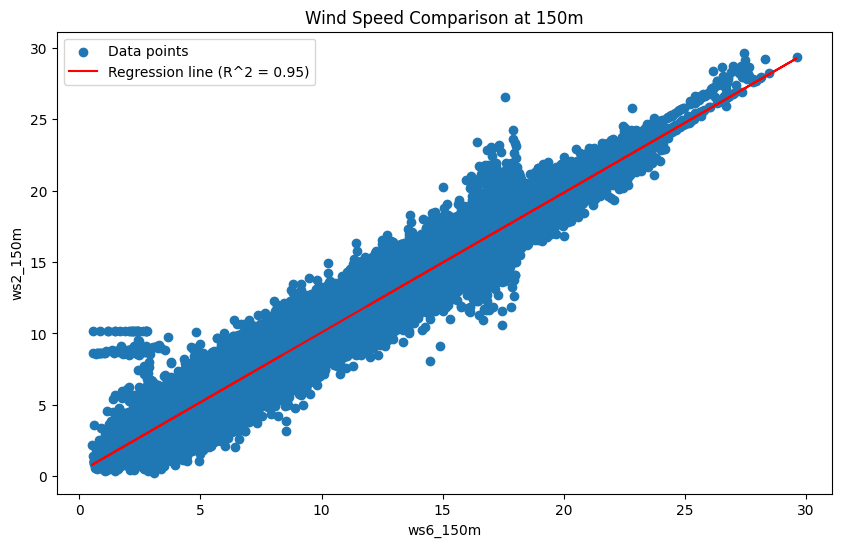

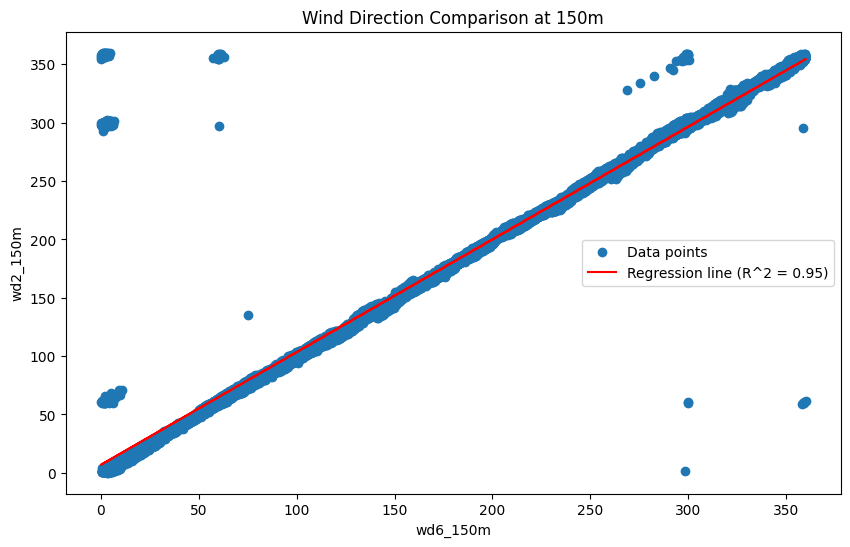

In [15]:
def plot_scatter_with_regression(x, y, xlabel, ylabel, title):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, label='Data points') #s=1 change scatter point size 

    # Plot regression line
    plt.plot(x, slope * x + intercept, color='red', label=f'Regression line (R^2 = {r_value**2:.2f})')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Scatter plot for wind speed
plot_scatter_with_regression(df_interpol_height['ws6_150m'], df_interpol_height['ws2_150m'], 'ws6_150m', 'ws2_150m', 'Wind Speed Comparison at 150m') #52704 intervall points for one year 

# Scatter plot for wind direction
plot_scatter_with_regression(df_interpol_height['wd6_150m'], df_interpol_height['wd2_150m'], 'wd6_150m', 'wd2_150m', 'Wind Direction Comparison at 150m')


#### Plot the Timeseries for Buoy 2 and 6 

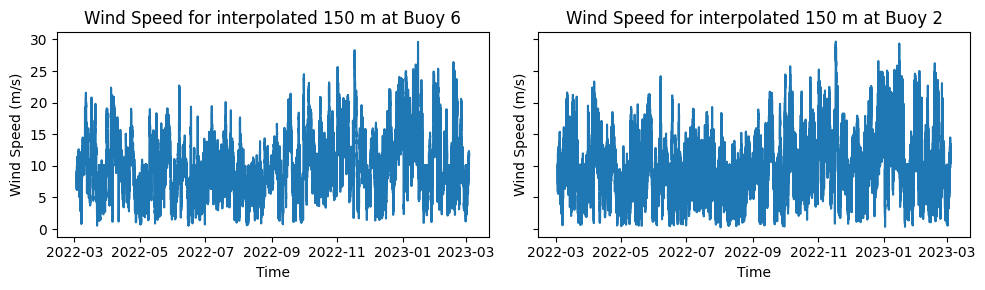

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True, sharex=True)

axes[0].plot(filtered_buoy6.index, ws6_150m)
axes[0].set_title('Wind Speed for interpolated 150 m at Buoy 6')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Wind Speed (m/s)')

axes[1].plot(filtered_buoy2.index, ws2_150m)
axes[1].set_title('Wind Speed for interpolated 150 m at Buoy 2')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Wind Speed (m/s)')


# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

### 8. Short Term Wind Analysis for the interpolated 150m height


In [17]:
def divide_into_bins_and_calculate_statistics(data_ws, data_wd, num_bins):
    # Calculate the size of each bin
    bin_size = len(data_ws) // num_bins
    
    # Initialize lists to store the means and standard deviations of each bin
    bin_means_ws = []
    bin_stdv_ws = []
    bin_means_wd = []
    bin_stdv_wd = []

    # Iterate through each bin
    for i in range(num_bins):
        # Determine the start and end indices of the bin
        start_idx = i * bin_size
        end_idx = start_idx + bin_size
        
        # Extract the bin data for wind speed and wind direction
        bin_data_ws = data_ws[start_idx:end_idx]
        bin_data_wd = data_wd[start_idx:end_idx]
        
        # Calculate the mean and standard deviation of the bin for wind speed
        bin_mean_ws = np.mean(bin_data_ws)
        bin_std_ws = np.std(bin_data_ws)
        
        # Calculate the mean and standard deviation of the bin for wind direction
        bin_mean_wd = np.mean(bin_data_wd)
        bin_std_wd = np.std(bin_data_wd)
        
        # Append the mean and standard deviation to their respective lists
        bin_means_ws.append(bin_mean_ws)
        bin_stdv_ws.append(bin_std_ws)
        bin_means_wd.append(bin_mean_wd)
        bin_stdv_wd.append(bin_std_wd)

    # Create a DataFrame from the lists
    df = pd.DataFrame({
        'Monthly Means WS': bin_means_ws,
        'Monthly Stdv WS': bin_stdv_ws,
        'Monthly Means WD': bin_means_wd,
        'Monthly Stdv WD': bin_stdv_wd
    })

    return df

# Calculate monthly statistics
monthly_stats_ws6 = divide_into_bins_and_calculate_statistics(ws6_150m, wd6_150m, 12)
monthly_stats_ws2 = divide_into_bins_and_calculate_statistics(ws2_150m, wd2_150m, 12)

# Print the resulting DataFrames
print("Monthly Statistics for Buoy 6:")
print(monthly_stats_ws6)

print("Monthly Statistics for Buoy 2:")
print(monthly_stats_ws2)


Monthly Statistics for Buoy 6:
    Monthly Means WS  Monthly Stdv WS  Monthly Means WD  Monthly Stdv WD
0           9.208057         4.391408        147.399176        96.344378
1           9.459077         4.524506        187.998138       111.109559
2           8.899916         4.155339        227.620852        81.324029
3           8.198149         3.692176        208.491740        79.990089
4           8.955226         3.251292        250.051628        77.755868
5           6.991824         3.012961        183.127782       106.995915
6           9.521834         4.677321        204.671325       108.726514
7          11.272452         4.151032        218.737248        51.533234
8          12.134411         4.959017        172.649631        66.872712
9          11.908850         5.040845        205.744059        83.298735
10         13.006125         5.827992        221.963638        74.431514
11         10.051740         5.256504        216.346685       100.637647
Monthly Statistics f

In [18]:
# Calculate yearly statistics for wind speed
yearly_mean_ws6 = np.mean(ws6_150m)
yearly_std_ws6 = np.std(ws6_150m)
yearly_mean_ws2 = np.mean(ws2_150m)
yearly_std_ws2 = np.std(ws2_150m)

print(f"Yearly Mean of Wind Speed Buoy 6: {yearly_mean_ws6:.2f}, Standard Deviation Buoy 6: {yearly_std_ws6:.2f}")
print(f"Yearly Mean of Wind Speed Buoy 2: {yearly_mean_ws2:.2f}, Standard Deviation Buoy 2: {yearly_std_ws2:.2f}")

# Calculate yearly statistics for wind direction
yearly_mean_wd6 = np.mean(wd6_150m)
yearly_std_wd6 = np.std(wd6_150m)
yearly_mean_wd2 = np.mean(wd2_150m)
yearly_std_wd2 = np.std(wd2_150m)

print(f"Yearly Mean of Wind Direction Buoy 6: {yearly_mean_wd6:.2f}, Standard Deviation Buoy 6: {yearly_std_wd6:.2f}")
print(f"Yearly Mean of Wind Direction Buoy 2: {yearly_mean_wd2:.2f}, Standard Deviation Buoy 2: {yearly_std_wd2:.2f}")


Yearly Mean of Wind Speed Buoy 6: 9.97, Standard Deviation Buoy 6: 4.79
Yearly Mean of Wind Speed Buoy 2: 10.04, Standard Deviation Buoy 2: 4.81
Yearly Mean of Wind Direction Buoy 6: 203.73, Standard Deviation Buoy 6: 92.18
Yearly Mean of Wind Direction Buoy 2: 203.51, Standard Deviation Buoy 2: 91.13


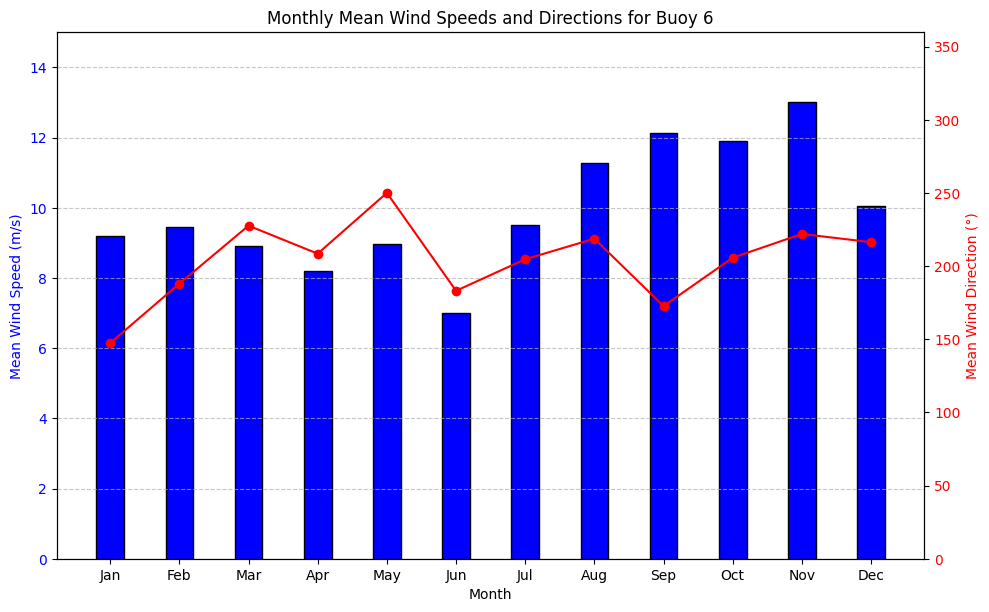

In [19]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Extract the monthly means from the dataframe
monthly_means_ws6 = monthly_stats_ws6['Monthly Means WS']
monthly_means_wd6 = monthly_stats_ws6['Monthly Means WD']

# Plot the monthly mean wind speeds and wind directions
fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.4  # Set bar width to half of the current width

# Bar plot for wind speeds
ax1.bar(months, monthly_means_ws6, color='blue', edgecolor='black', label='Mean Wind Speed', width=bar_width)
ax1.set_xlabel('Month')
ax1.set_ylabel('Mean Wind Speed (m/s)', color='blue')
ax1.set_ylim(0, max(monthly_means_ws6) + 2)  # Adjust y-axis limit for better visualization
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(months, monthly_means_wd6, color='red', marker='o', linestyle='-', label='Mean Wind Direction')
ax2.set_ylabel('Mean Wind Direction (°)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 360)  # Assuming wind direction is in degrees

fig.tight_layout()
plt.title('Monthly Mean Wind Speeds and Directions for Buoy 6')
plt.show()


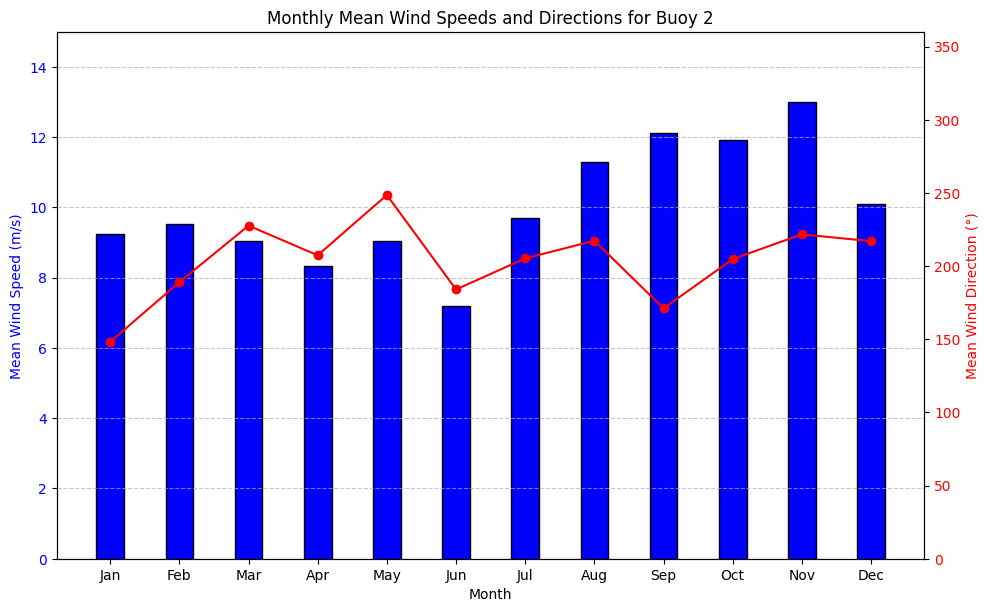

In [20]:
# Extract the monthly means from the dataframe
monthly_means_ws2 = monthly_stats_ws2['Monthly Means WS']
monthly_means_wd2 = monthly_stats_ws2['Monthly Means WD']

# Plot the monthly mean wind speeds and wind directions
fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.4  # Set bar width to half of the current width

# Bar plot for wind speeds
ax1.bar(months, monthly_means_ws2, color='blue', edgecolor='black', label='Mean Wind Speed', width=bar_width)
ax1.set_xlabel('Month')
ax1.set_ylabel('Mean Wind Speed (m/s)', color='blue')
ax1.set_ylim(0, max(monthly_means_ws2) + 2)  # Adjust y-axis limit for better visualization
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(months, monthly_means_wd2, color='red', marker='o', linestyle='-', label='Mean Wind Direction')
ax2.set_ylabel('Mean Wind Direction (°)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 360)  # Assuming wind direction is in degrees

fig.tight_layout()
plt.title('Monthly Mean Wind Speeds and Directions for Buoy 2')
plt.show()


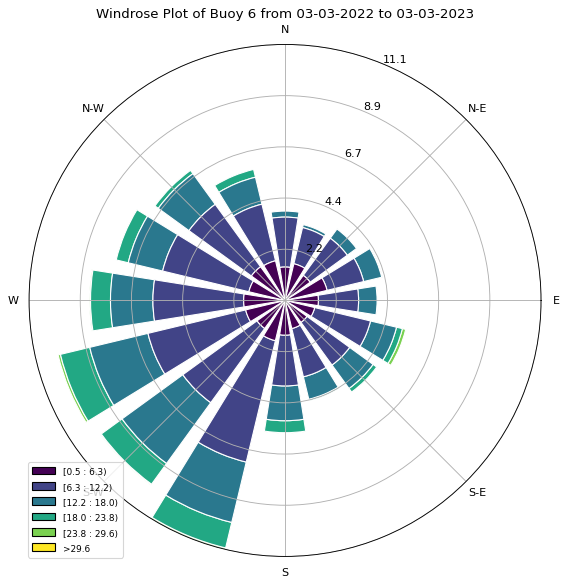

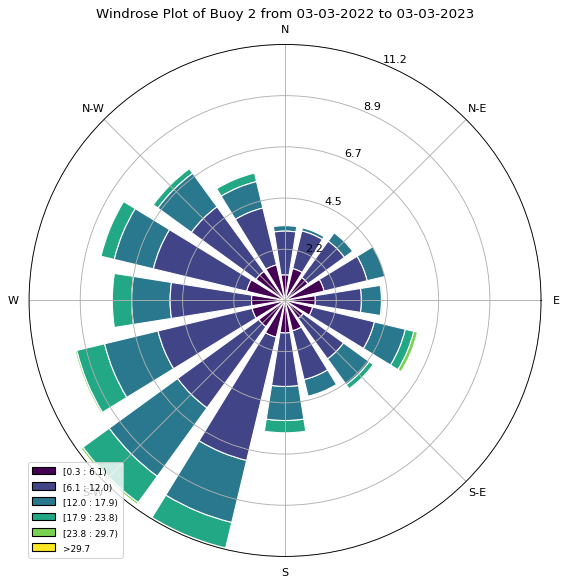

In [22]:
from windrose import WindroseAxes

def plot_wind_rose(wd, ws, title):
    ax = WindroseAxes.from_ax()
    ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    plt.title(title)
    plt.show()

plot_wind_rose(df_interpol_height['wd6_150m'], df_interpol_height['ws6_150m'], 'Windrose Plot of Buoy 6 from 03-03-2022 to 03-03-2023' )
plot_wind_rose(df_interpol_height['wd2_150m'], df_interpol_height['ws2_150m'], 'Windrose Plot of Buoy 2 from 03-03-2022 to 03-03-2023' )